* `Import Libraries`

In [ ]:

import numpy as np 
import pandas as pd 
import joblib 
import wordcloud
import os 
import re 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud

import nltk
import spacy
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Abdallah
[nltk_data]     Samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

*  `Read The Dataset`

In [2]:
FILE_PATH = os.path.join(os.getcwd(),"Fake.csv") 
df = pd.read_csv(FILE_PATH) 
df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

* `EDA`

In [3]:
df.shape

(23481, 4)

In [4]:
df['subject'].value_counts(normalize=True)

subject
News               0.385418
politics           0.291342
left-news          0.189898
Government News    0.066863
US_News            0.033346
Middle-east        0.033133
Name: proportion, dtype: float64

In [28]:
label_encoder = LabelEncoder()
# df['subject_encoded'] = label_encoder.fit_transform(df['subject'])
df['subject_encoded'].value_counts()

subject_encoded
2    9050
5    6841
4    4459
0    1570
3     783
1     778
Name: count, dtype: int64

In [6]:
df['full_text'] = df['title'] + ' ' + df['text']
df = df.drop(['title', 'text'], axis=1)
df.drop(['date','subject'],axis=1,inplace=True)

In [7]:
df.head()

subject_encoded                                          full_text
0                2   Donald Trump Sends Out Embarrassing New Year’...
1                2   Drunk Bragging Trump Staffer Started Russian ...
2                2   Sheriff David Clarke Becomes An Internet Joke...
3                2   Trump Is So Obsessed He Even Has Obama’s Name...
4                2   Pope Francis Just Called Out Donald Trump Dur...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subject_encoded  23481 non-null  int32 
 1   full_text        23481 non-null  object
dtypes: int32(1), object(1)
memory usage: 275.3+ KB


In [9]:
df.shape

(23481, 2)

In [10]:
df.describe()

subject_encoded
count     23481.000000
mean          3.120310
std           1.568633
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           5.000000

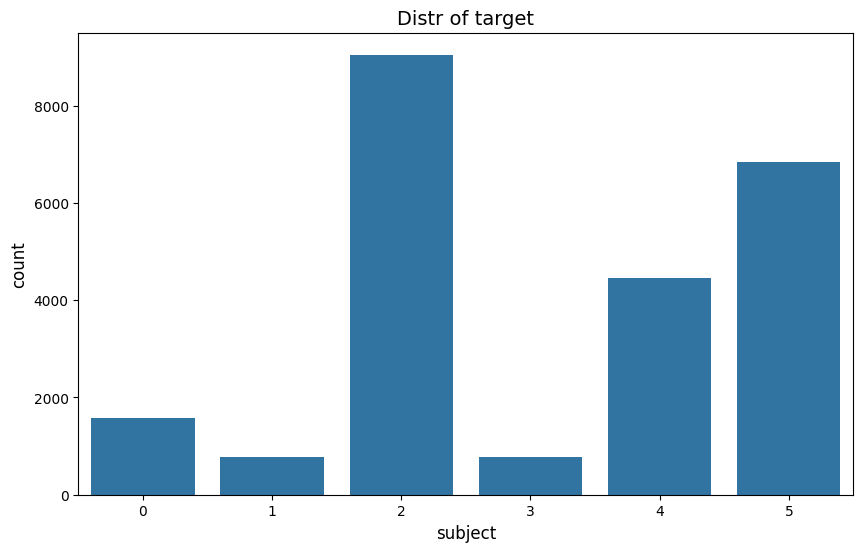

In [11]:
plt.figure(figsize=(10,6)) 
sns.countplot(data=df,x='subject_encoded') 
plt.title('Distr of target',fontsize=14,c='k') 
plt.xlabel('subject',c='k',fontsize=12) 
plt.ylabel('count',c='k',fontsize=12)
plt.show()

* `Text Cleaning & Vizualization`

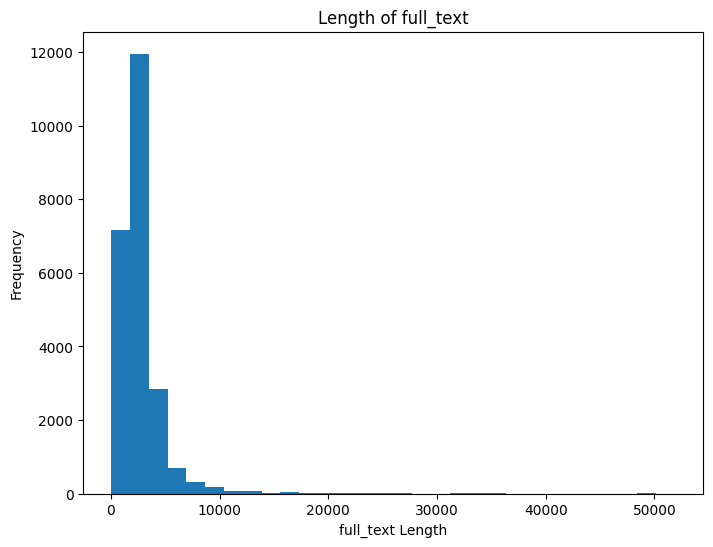

In [12]:
# Sequence Length
length_review = df['full_text'].str.len()
plt.figure(figsize=(8, 6))
plt.hist(length_review, bins=30)
plt.title('Length of full_text')
plt.xlabel('full_text Length')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Remove unwanted text patterns from the review
def remove_pattern(input_text,pattern):
    return re.sub(pattern,' ',input_text)

* `Remove Punctuation, Numbers, Special Chars`

In [14]:
# Remove special characters and digits and Convert to lowercase
df['full_text'] = df['full_text'].str.lower()
df.loc[:,'full_text'] = df['full_text'].apply(lambda x :remove_pattern(x,r'[^a-zA-Z\s]'))
df.loc[:,'full_text'] = df['full_text'].str.replace('\s+', ' ',regex=True)
df.head()

subject_encoded                                          full_text
0                2   donald trump sends out embarrassing new year ...
1                2   drunk bragging trump staffer started russian ...
2                2   sheriff david clarke becomes an internet joke...
3                2   trump is so obsessed he even has obama s name...
4                2   pope francis just called out donald trump dur...

#### `Remove Repeated Characters`

In [15]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    # Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    # Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
df.loc[:, 'full_text'] = df['full_text'].apply(remove_excessive_repeated_characters)
df.head()

subject_encoded                                          full_text
0                2   donald trump sends out embarrassing new year ...
1                2   drunk bragging trump staffer started russian ...
2                2   sheriff david clarke becomes an internet joke...
3                2   trump is so obsessed he even has obama s name...
4                2   pope francis just called out donald trump dur...

* `Removing short words`

In [16]:
df.loc[:, 'full_text'] = df['full_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
df.head()

subject_encoded                                          full_text
0                2  donald trump sends embarrassing year message t...
1                2  drunk bragging trump staffer started russian c...
2                2  sheriff david clarke becomes internet joke thr...
3                2  trump obsessed even obama name coded into webs...
4                2  pope francis just called donald trump during c...

* `Remove Numbers from Words`

In [17]:
df.loc[:, 'full_text'] = df['full_text'].apply(lambda x: remove_pattern(x, '(?<=\w)\d+|\d+(?=\w)'))
df.head()

subject_encoded                                          full_text
0                2  donald trump sends embarrassing year message t...
1                2  drunk bragging trump staffer started russian c...
2                2  sheriff david clarke becomes internet joke thr...
3                2  trump obsessed even obama name coded into webs...
4                2  pope francis just called donald trump during c...

* `Rmeove Redundant words`

In [18]:
# A Function to remove redundant words like (I've, You'll)
# Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    # Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


# Apply the above function
df.loc[:, 'full_text'] = df['full_text'].apply(remove_redundant_words_extra_spaces)
df.head()

subject_encoded                                          full_text
0                2  donald trump sends embarrassing year message d...
1                2  drunk bragging trump staffer started russian c...
2                2  sheriff david clarke becomes internet joke thr...
3                2  trump obsessed even obama name coded website i...
4                2  pope francis called donald trump christmas spe...

* `Remove Special Chars`

In [19]:
df.loc[:, 'full_text'] = df['full_text'].apply(lambda x: remove_pattern(x, r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
df.head()

subject_encoded                                          full_text
0                2  donald trump sends embarrassing year message d...
1                2  drunk bragging trump staffer started russian c...
2                2  sheriff david clarke becomes internet joke thr...
3                2  trump obsessed even obama name coded website i...
4                2  pope francis called donald trump christmas spe...

In [20]:
# Create a folder for cleaned dataset
Cleaned_Dataset = os.path.join(os.getcwd(),'Fake_cleaned_dataset') 
os.makedirs(Cleaned_Dataset,exist_ok=True) 

In [21]:
# Download the dataset here at this step before Lemmatizing
df.to_csv(os.path.join(Cleaned_Dataset, "Fake_cleaned_dataset.csv"), index=False)

* `Tokenization`

In [22]:
tokenize_full_text = df['full_text'].apply(lambda x : word_tokenize(x)) 
tokenize_full_text.head()

0    [donald, trump, sends, embarrassing, year, mes...
1    [drunk, bragging, trump, staffer, started, rus...
2    [sheriff, david, clarke, becomes, internet, jo...
3    [trump, obsessed, even, obama, name, coded, we...
4    [pope, francis, called, donald, trump, christm...
Name: full_text, dtype: object

* `lemmatization`

In [23]:
lemmatizer = WordNetLemmatizer() 
tokenize_full_text = tokenize_full_text.apply(lambda x:[lemmatizer.lemmatize(i) for i in x]) 
tokenize_full_text

0        [donald, trump, sends, embarrassing, year, mes...
1        [drunk, bragging, trump, staffer, started, rus...
2        [sheriff, david, clarke, becomes, internet, jo...
3        [trump, obsessed, even, obama, name, coded, we...
4        [pope, francis, called, donald, trump, christm...
                               ...                        
23476    [mcpain, john, mccain, furious, iran, treated,...
23477    [justice, yahoo, settle, mail, privacy, class,...
23478    [sunnistan, allied, safe, zone, plan, take, te...
23479    [blow, million, jazeera, america, finally, cal...
23480    [navy, sailor, held, iranian, military, sign, ...
Name: full_text, Length: 23481, dtype: object

In [24]:
df.loc[:,'full_text'] = tokenize_full_text.apply(lambda x : ' '.join(x)) 
df.head()

subject_encoded                                          full_text
0                2  donald trump sends embarrassing year message d...
1                2  drunk bragging trump staffer started russian c...
2                2  sheriff david clarke becomes internet joke thr...
3                2  trump obsessed even obama name coded website i...
4                2  pope francis called donald trump christmas spe...

In [25]:
os.path.join(Cleaned_Dataset,'Fake_cleaned_dataset.csv')

'c:\\Users\\Abdallah Samir\\Desktop\\ELEVVO\\src\\notebooks\\Fake_cleaned_dataset\\Fake_cleaned_dataset.csv'

* `Some Viz with Wordcloud`

* `Bonus`

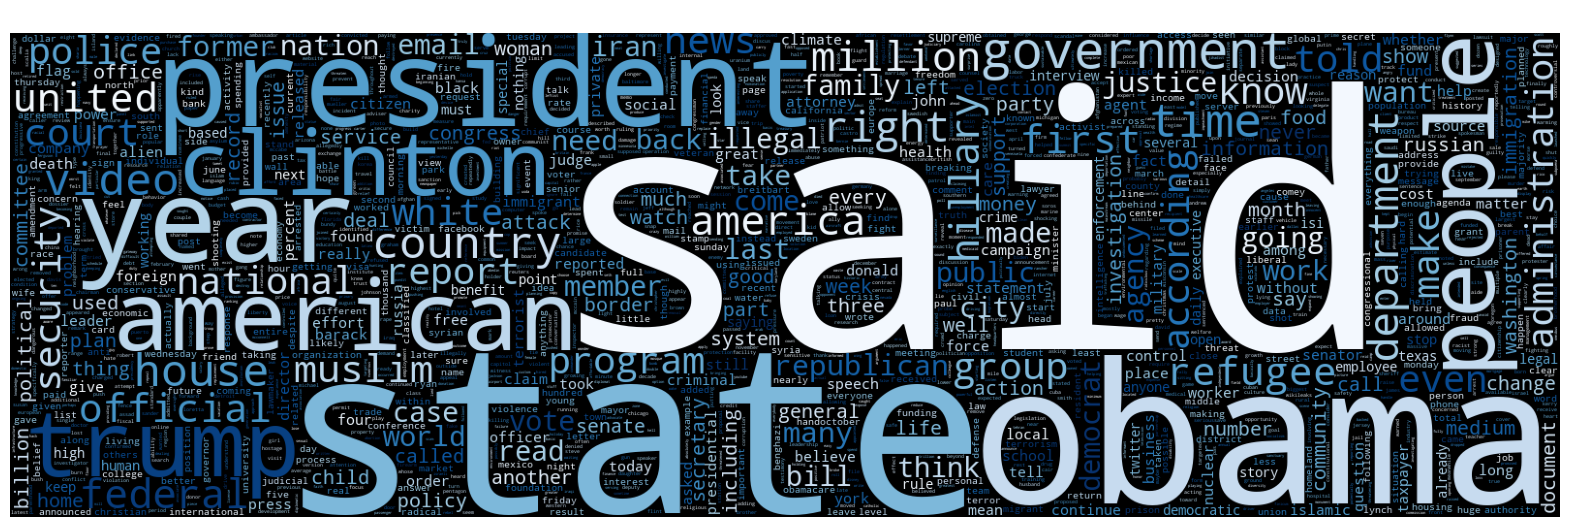

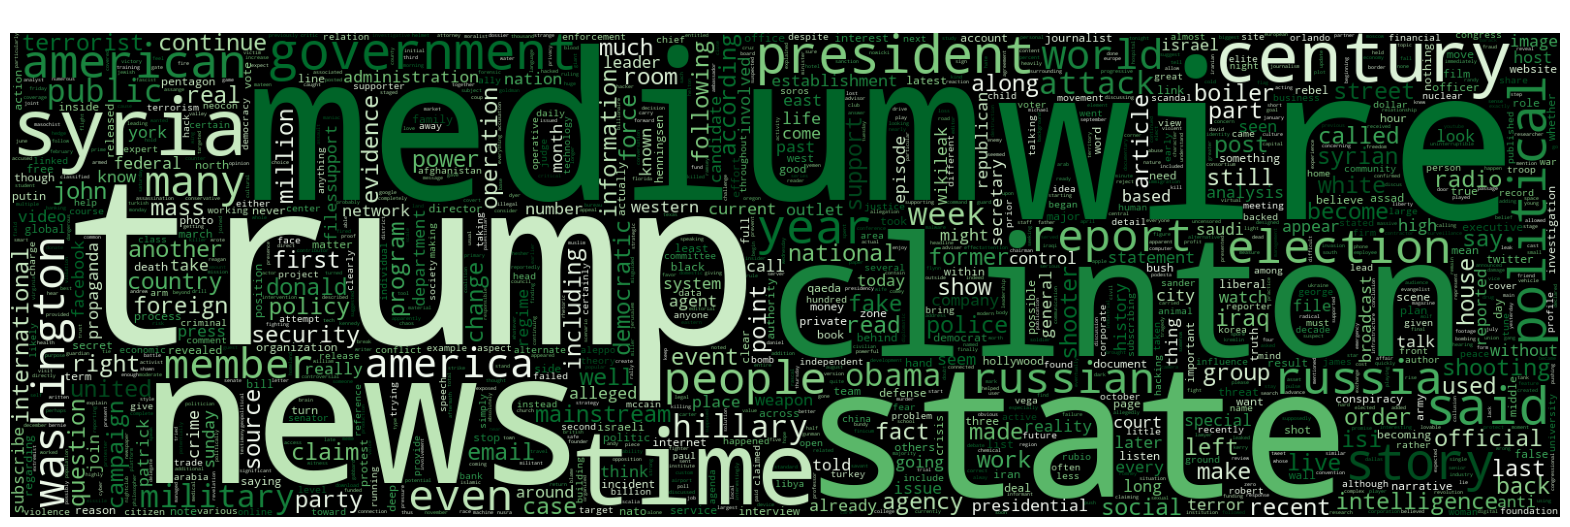

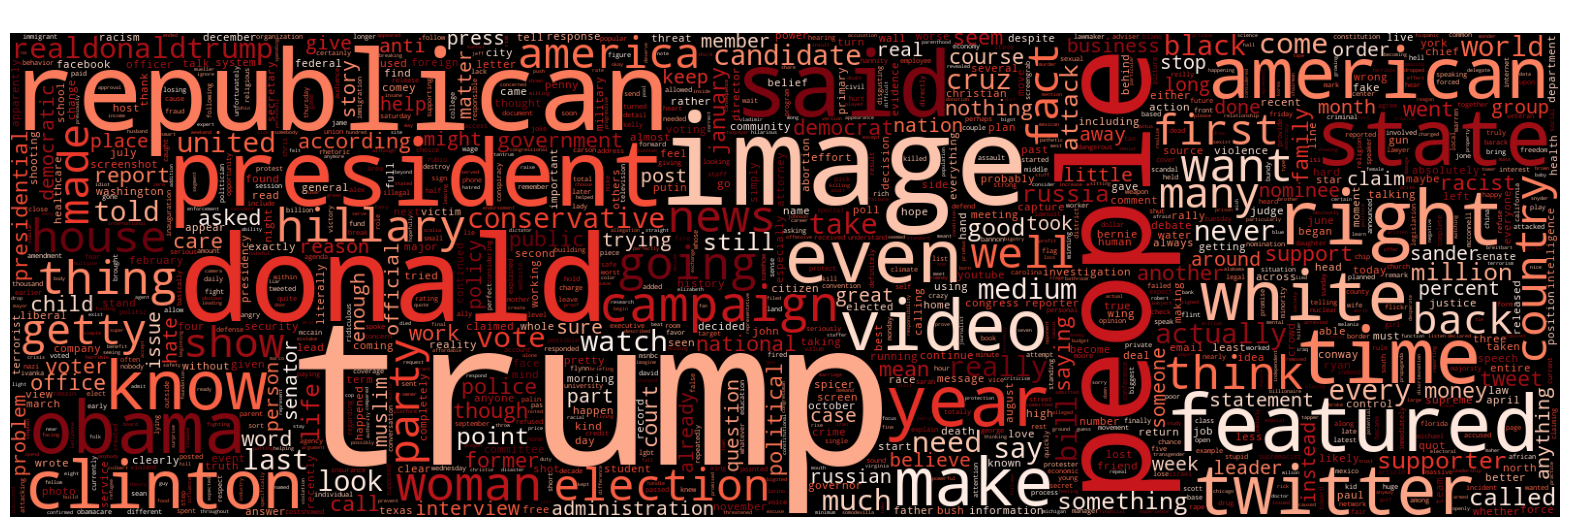

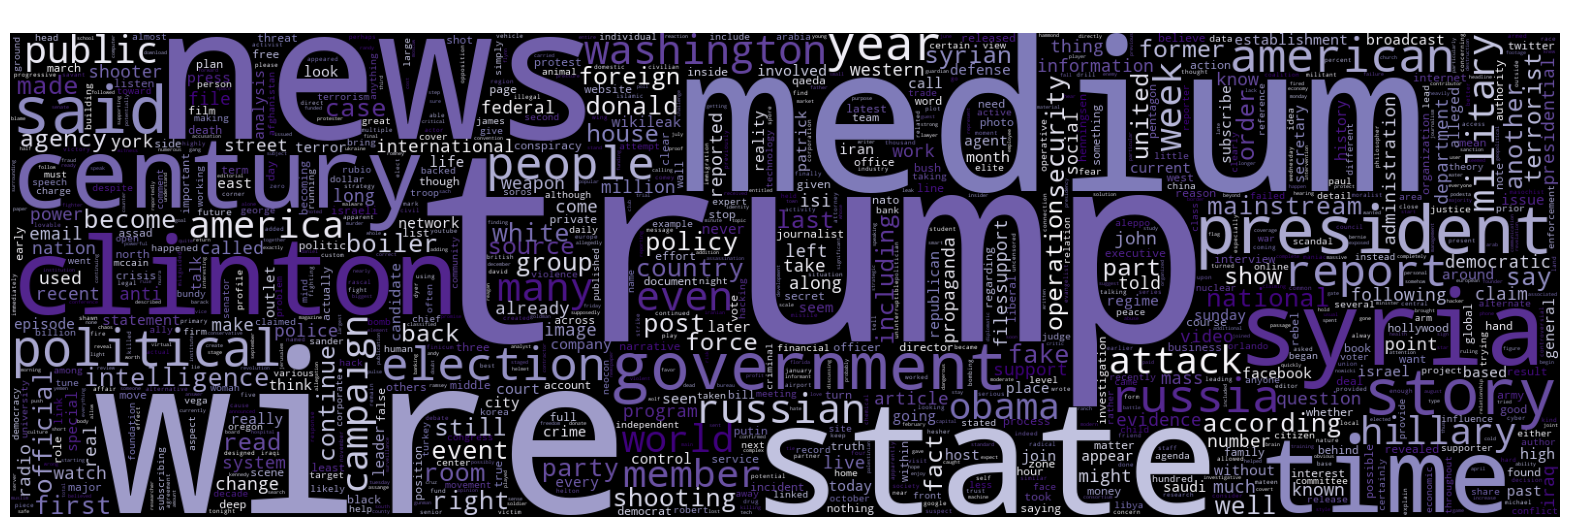

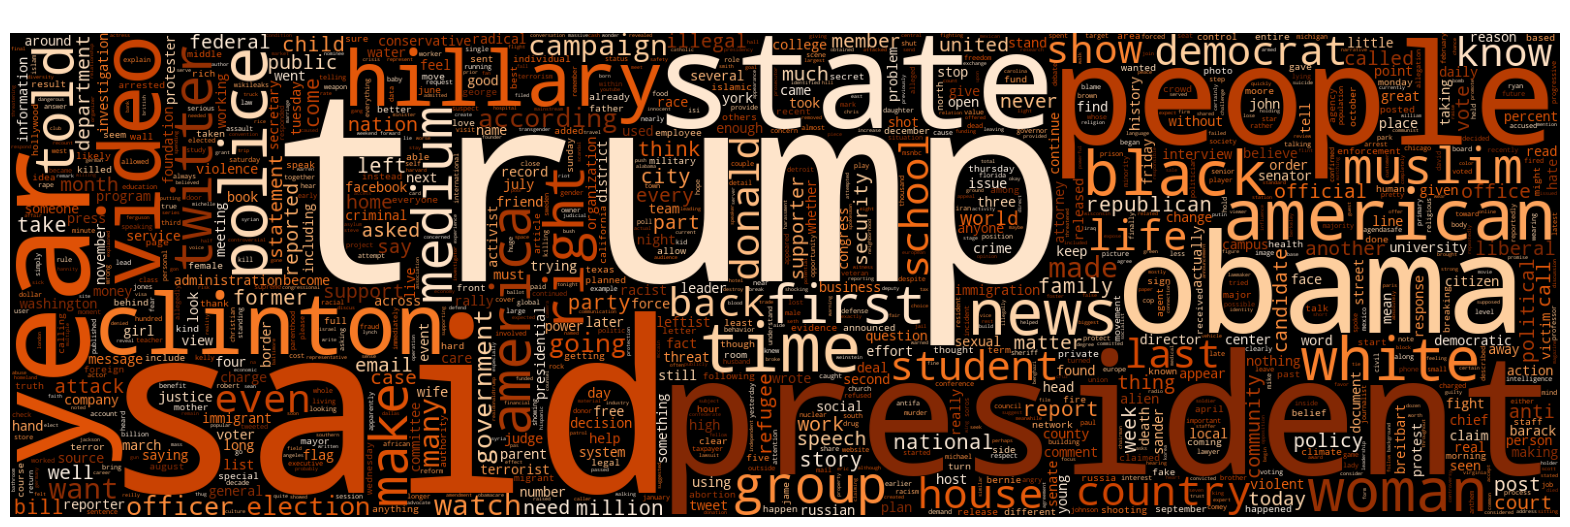

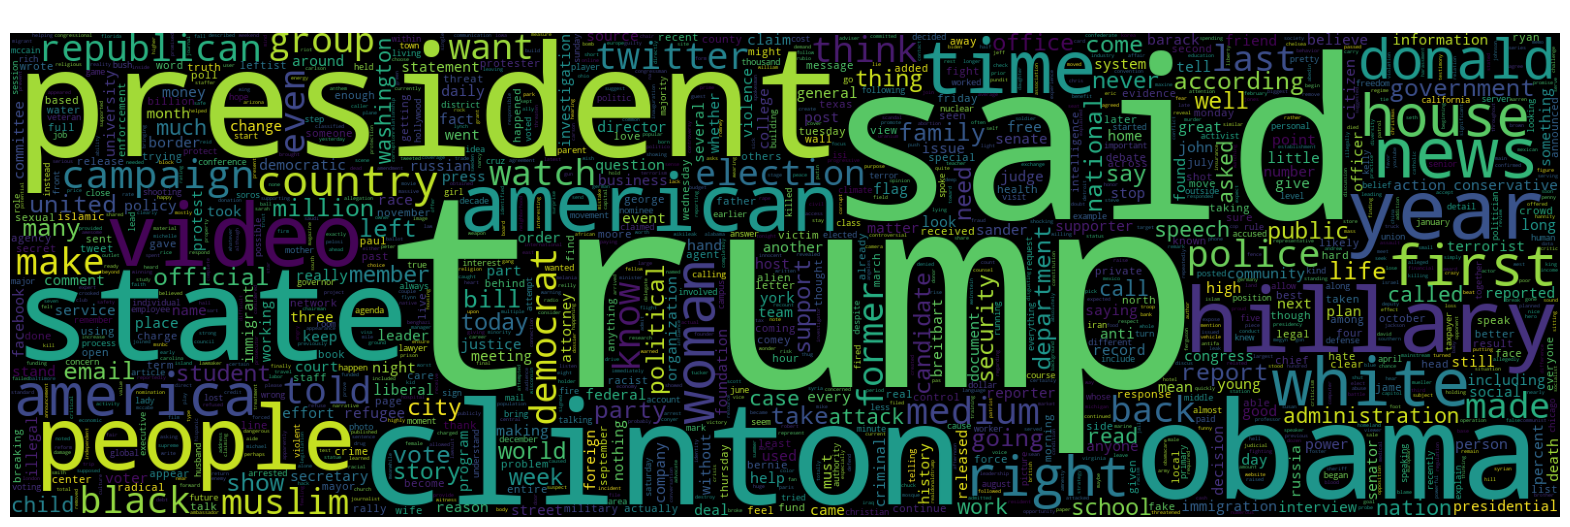

In [29]:
classes = [0, 1, 2, 3, 4, 5]
colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'viridis']
class_names = ['General News', 'Politics', 'World News', 'Government', 'US News', 'Middle East'] 

for i, class_idx in enumerate(classes):
    category_df = df[df['subject_encoded'] == class_idx]
    
    plt.figure(figsize=(20, 8))
    wc = WordCloud(max_words=10000, width=1600, height=500,
                   background_color='black', collocations=False,
                   colormap=colors[i]).generate(' '.join(category_df['full_text'].astype(str)))
    plt.title(f'Class {class_idx} ({class_names[i]}) News Visualization', fontsize=14, c='white')
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

* ` Text Vectorization`

* ` CountVectorizer(BOW)`

In [30]:
bow_vectorizer = CountVectorizer(max_df=0.90,min_df=4,max_features=5000,stop_words='english') 
X_bow = bow_vectorizer.fit_transform(df['full_text']) 
X_bow = X_bow.todense() 
X_bow

matrix([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 1,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  1, 14,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

* `2. TF-IDF` 

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['full_text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05084691, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01016975, 0.15358218,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [32]:
X_bow.shape , X_tfidf.shape

((23481, 5000), (23481, 5000))

* `Glove`

In [59]:
nlp = spacy.load('en_core_web_md') 
X_glove = np.array([nlp(text).vector for text in tqdm(df["full_text"])])
X_glove

100%|██████████| 23481/23481 [22:56<00:00, 17.05it/s] 


array([[-0.6542325 ,  0.01193901, -0.01841141, ..., -0.03735962,
        -0.06133397,  0.05011525],
       [-0.7126998 ,  0.07915852,  0.07542393, ..., -0.01074423,
        -0.02889124,  0.0161656 ],
       [-0.6513393 ,  0.06690881, -0.00999011, ..., -0.06249731,
        -0.05810091,  0.06639799],
       ...,
       [-0.6970997 ,  0.06577718,  0.01913882, ..., -0.04539838,
        -0.05874098,  0.10738076],
       [-0.7093922 ,  0.1197009 ,  0.02262616, ..., -0.12037966,
        -0.04471901,  0.09019504],
       [-0.69104856,  0.05166116,  0.08307037, ..., -0.00644425,
        -0.08439513,  0.06947726]], dtype=float32)

* `Split the data`

In [77]:
X = X_glove
y = df['subject_encoded']

In [78]:
X_train,X_test,y_train,y_test = train_test_split(X_glove,y,test_size=0.2,random_state=45,shuffle=True,stratify=y)

* `Deal Imbalanced Data`

In [79]:
class_weights = compute_class_weight('balanced', 
                                    classes=np.unique(y_train), 
                                    y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

svc_clf = LinearSVC(C=1.5, max_iter=1000, random_state=45, 
                    class_weight=class_weight_dict)

* `Building Models`

* `LogisticRegression`

In [82]:
log_clf = LogisticRegression(C=1.5,max_iter=10000,random_state=45,class_weight=class_weight_dict)
log_clf.fit(X_train,y_train )

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train)
y_pred_test_log = log_clf.predict(X_test)

# Using f1_score
score_train_log = accuracy_score(y_train, y_pred_train_log)
score_test_log = accuracy_score(y_test, y_pred_test_log)

f1_train_log = f1_score(y_train, y_pred_train_log, average='weighted')
f1_test_log = f1_score(y_test, y_pred_test_log, average='weighted')

print(f'The accuracy_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The accuracy_score using Logistic model for Testing Dataset  is {score_test_log*100:.3f}') 
print(f'The F1-score (weighted) for Training Dataset is {f1_train_log*100:.3f}%')
print(f'The F1-score (weighted) for Testing Dataset is {f1_test_log*100:.3f}%')

The accuracy_score using Logistic model for Training Dataset is 56.804
The accuracy_score using Logistic model for Testing Dataset  is 53.098
The F1-score (weighted) for Training Dataset is 57.240%
The F1-score (weighted) for Testing Dataset is 53.625%


* ` SVM classifier`

In [80]:
class_weights = compute_class_weight('balanced', 
                                    classes=np.unique(y_train), 
                                    y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Class weights:")
for class_label, weight in class_weight_dict.items():
    print(f"Class {class_label}: {weight:.3f}")

# Linear SVC with class weights
svc_clf = LinearSVC(C=1.5, max_iter=1000, random_state=45, 
                    class_weight=class_weight_dict)
svc_clf.fit(X_train, y_train)

# Predict and evaluate SVC
y_pred_train_svc = svc_clf.predict(X_train)
y_pred_test_svc = svc_clf.predict(X_test)

score_train_svc = accuracy_score(y_train, y_pred_train_svc)
score_test_svc = accuracy_score(y_test, y_pred_test_svc)
f1_train_svc = f1_score(y_train, y_pred_train_svc, average='weighted')
f1_test_svc = f1_score(y_test, y_pred_test_svc, average='weighted') 
print(f'The accuracy_score using Linear SVC for Training Dataset is {score_train_svc*100:.3f}%')
print(f'The accuracy_score using Linear SVC for Testing Dataset is {score_test_svc*100:.3f}%')
print(f'The F1-score (weighted) for Training Dataset is {f1_train_svc*100:.3f}%')
print(f'The F1-score (weighted) for Testing Dataset is {f1_test_svc*100:.3f}%')

Class weights:
Class 0: 2.493
Class 1: 5.033
Class 2: 0.432
Class 3: 5.001
Class 4: 0.878
Class 5: 0.572
The accuracy_score using Linear SVC for Training Dataset is 61.276%
The accuracy_score using Linear SVC for Testing Dataset is 57.100%
The F1-score (weighted) for Training Dataset is 60.721%
The F1-score (weighted) for Testing Dataset is 56.702%
